## Step 1: Import Required Libraries

In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Step 2: Load and Clean the Data
We'll start by loading the dataset and checking for missing values or inconsistencies.

In [2]:
# Load dataset
df = pd.read_csv('StudentsPerformance.csv')

# Display first few rows
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Check for missing values
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [4]:
# View data structure
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


### Data Cleaning and Feature Engineering

In [7]:
# Create average score column
df['average_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# Define pass/fail: pass if average score >= 40
df['pass/fail'] = df['average_score'].apply(lambda x: 1 if x >= 40 else 0)

# Encode categorical features
cat_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average_score,pass/fail
0,0,1,1,1,1,72,72,74,72.666667,1
1,0,2,4,1,0,69,90,88,82.333333,1
2,0,1,3,1,1,90,95,93,92.666667,1
3,1,0,0,0,1,47,57,44,49.333333,1
4,1,2,4,1,1,76,78,75,76.333333,1


In [8]:
df['pass/fail'].value_counts()

pass/fail
1    970
0     30
Name: count, dtype: int64

## Step 3: Exploratory Data Analysis (EDA)
We’ll explore the distribution of scores and their relationship with demographic features and target variable.

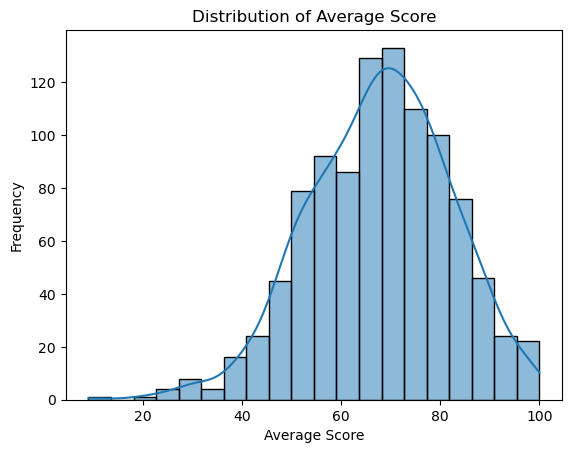

In [9]:
# Distribution of average score
sns.histplot(df['average_score'], bins=20, kde=True)
plt.title('Distribution of Average Score')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

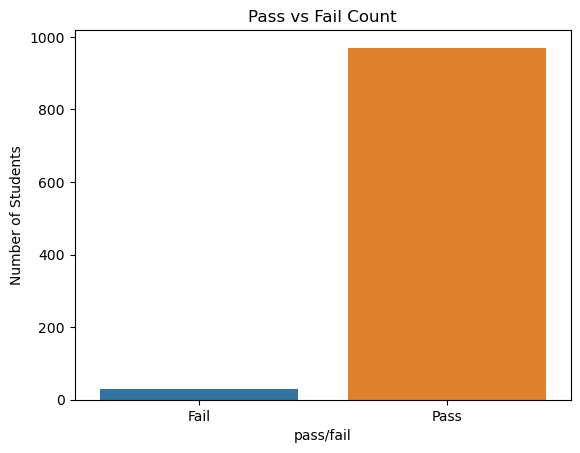

In [10]:
# Pass/fail distribution
sns.countplot(x='pass/fail', data=df)
plt.title('Pass vs Fail Count')
plt.xticks([0, 1], ['Fail', 'Pass'])
plt.ylabel('Number of Students')
plt.show()

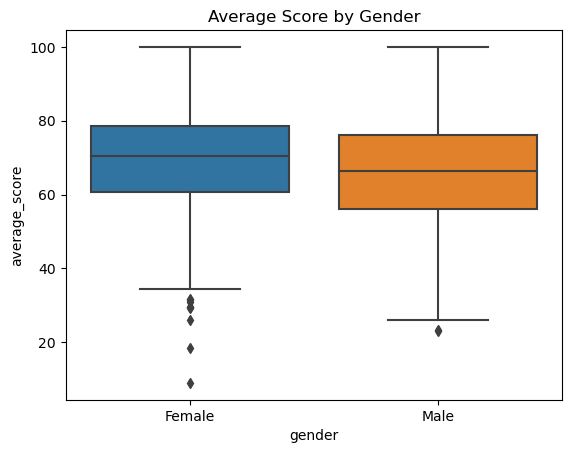

In [11]:
# Boxplot of average score by gender
sns.boxplot(x='gender', y='average_score', data=df)
plt.title('Average Score by Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

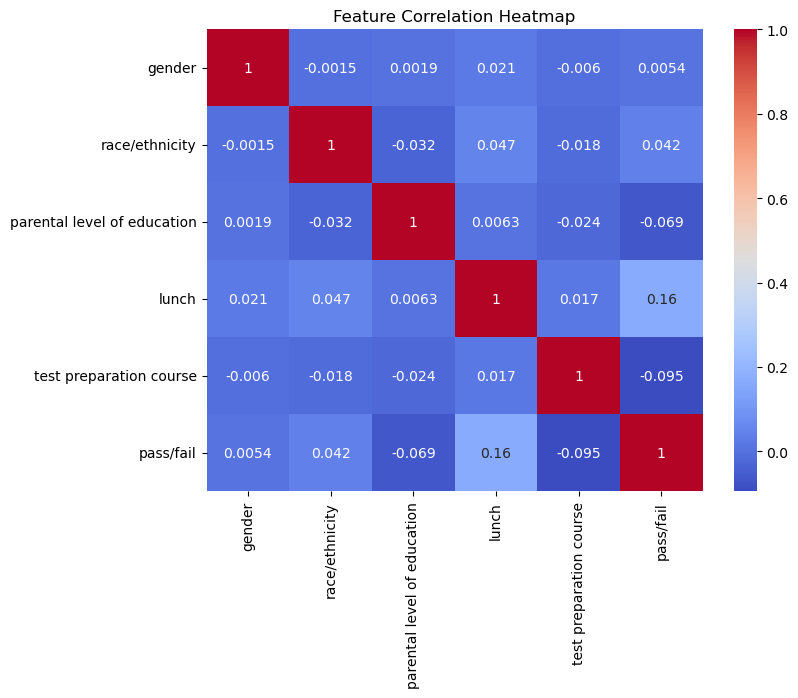

In [12]:
# Correlation heatmap with non-leaky features
features_for_corr = df[cat_cols + ['pass/fail']]
plt.figure(figsize=(8, 6))
sns.heatmap(features_for_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Step 4: Model Building – Logistic Regression & Random Forest
We will use Logistic Regression and Random Forest to predict whether a student will pass.

### Handling Class Imbalance

Since the dataset is highly imbalanced (only 30 students failed out of 1000), we use `class_weight='balanced'` in our models. This parameter adjusts weights inversely proportional to class frequencies, helping the model give more importance to the minority class (fail) and avoid bias toward the majority class (pass).

In [13]:
# Define feature matrix X
X = df[cat_cols]
y = df['pass/fail']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## Step 5: Model Evaluation
Let’s evaluate both models using accuracy, confusion matrix, and F1-score.

In [14]:
# Logistic Regression Evaluation
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.69
Confusion Matrix:
 [[  6   4]
 [ 58 132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.60      0.16        10
           1       0.97      0.69      0.81       190

    accuracy                           0.69       200
   macro avg       0.53      0.65      0.49       200
weighted avg       0.93      0.69      0.78       200



In [15]:
# Random Forest Evaluation
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.855
Confusion Matrix:
 [[  1   9]
 [ 20 170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.10      0.06        10
           1       0.95      0.89      0.92       190

    accuracy                           0.85       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.90      0.85      0.88       200



### Conclusion

So, although Random Forest achieves higher accuracy, it still suffers from class imbalance — something that could be further mitigated through techniques like SMOTE or better sampling.
That’s why Logistic Regression may be preferred here, as it better identifies students who are at risk of failing, which is more important in an educational setting.